In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0



Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [ ]:
from convert_mesh import convert_mesh


volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)

nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)

In [2]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_1 import run_festim_1
    import time

    start = time.perf_counter()
    run_festim_1(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

In [3]:
import ipyparallel as ipp
import numpy as np
import os

if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")

    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    print(elapsed_times)

    # get the maximum runtime
    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

# save data to csv
import pandas as pd
df = pd.DataFrame(data={"num_procs": num_procs, "runtimes": runtimes})
df.to_csv("runtimes_festim_1.csv", index=False)

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.56s/engine]
[8.153220230999978]
Elapsed times: [8.153220230999978] seconds, max runtime=8.15e+00
Running with 2 processes
Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.76s/engine]
[34.22458866599936, 34.248421153999516]
Elapsed times: [34.22458866599936, 34.248421153999516] seconds, max runtime=3.42e+01
Running with 4 processes
Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.39s/engine]
[48.95167861099981, 48.95302976499988, 48.9518952340004, 48.952794109000024]
Elapsed times: [48.95167861099981, 48.95302976499988, 48.9518952340004, 48.952794109000024] seconds, max runtime=4.90e+01
Running with 8 processes
Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|

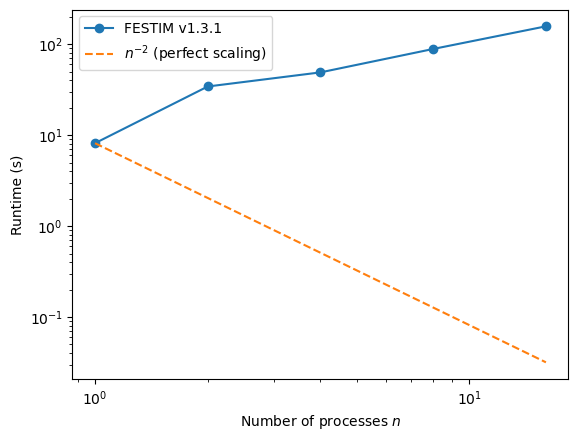

In [4]:
import matplotlib.pyplot as plt
from festim import __version__

plt.plot(num_procs, runtimes, marker="o", label=f"FESTIM v{__version__}")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-2, linestyle="--", label="$n^{-2}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()